In [1]:
import os
import torch
from torch.utils.data import Dataset , DataLoader
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
device = torch.device("cuda:0")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enable = True

class DataReader(Dataset):

    def __init__(self,dirName, tranform=None):
        self.listOfFile = self.getListOfFiles(dirName)
        
    def __len__(self):
        return len(self.listOfFile) // 3

    def __getitem__(self, index):
        x = Image.open(self.listOfFile[index * 3])
        y = Image.open(self.listOfFile[(index * 3)+1])
        x2 = Image.open(self.listOfFile[(index * 3)+2])
        x = TF.to_tensor(x)
        y = TF.to_tensor(y)
        x2 = TF.to_tensor(x2)
        
        return [torch.cat((x, x2)), y]

    def getListOfFiles(self, dirName):
        listOfFile = os.listdir(dirName)
        allFiles = []
        for entry in listOfFile:
            fullPath = os.path.join(dirName, entry)
            if os.path.isdir(fullPath):
                allFiles = allFiles + self.getListOfFiles(fullPath)
            else:
                allFiles.append(fullPath)
        return allFiles

dirName = r"C:\Users\user\Desktop\vimeo_triplet\sequences"

data = DataReader(dirName)
batch_size = 4
data_loarder = DataLoader(data, batch_size= batch_size, shuffle = True)


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.pack1 = self.convolution_pack(6,64)
        self.pack2 = self.convolution_pack(64,128)
        self.pack3 = self.convolution_pack(128,256)
        self.pack4 = self.convolution_pack(256,512)
        self.pack5 = self.convolution_pack(512,1024)
        self.depack1 = self.convolution_pack(1024,512)
        self.depack2 = self.convolution_pack(512,256)
        self.depack3 = self.convolution_pack(256,128)
        self.depack4 = self.convolution_pack(128,64)
        self.depack5 = self.convolution_pack(64,3)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaimingnormal(m.weight)
    
    def convolution_pack(self,channels_in,channels_out):
        return torch.nn.Sequential(
				torch.nn.Conv2d(channels_in,channels_out,3,padding=1),
				torch.nn.ReLU(),
				torch.nn.Conv2d(channels_out,channels_out,3,padding=1),
				torch.nn.ReLU(),
				torch.nn.Conv2d(channels_out,channels_out,3,padding=1),
				torch.nn.ReLU()
			)
    
    def forward(self, x):
        pack1 = F.avg_pool2d(self.pack1(x),(2,2))
        pack2 = F.avg_pool2d(self.pack2(pack1),(2,2))
        pack3 = F.avg_pool2d(self.pack3(pack2),(2,2))
        pack4 = F.avg_pool2d(self.pack4(pack3),(2,2))
        pack5 = F.avg_pool2d(self.pack5(pack4),(2,2))
        x = F.interpolate(self.depack1(pack5),scale_factor=2)
        x = F.interpolate(self.depack2(x+pack4),scale_factor=2)
        x = F.interpolate(self.depack3(x+pack3),scale_factor=2)
        x = F.interpolate(self.depack4(x+pack2),scale_factor=2)
        x = F.interpolate(self.depack5(x+pack1),scale_factor=2)
        return x
    
net = Net().to(device)

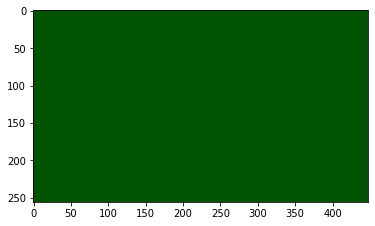

In [7]:
import matplotlib.pyplot as plt
for x,y in data_loarder:
    plt.imshow(TF.to_pil_image(net(x.to(device))[0].cpu()))
    break


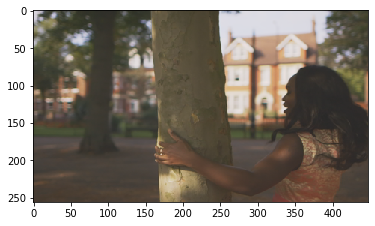

In [8]:
plt.imshow(TF.to_pil_image(y[0]))

In [3]:
import torch.optim as optim
from tqdm import tqdm
from pytorch_msssim import MS_SSIM

ms_ssim_module = MS_SSIM(data_range=255, size_average=True, channel=3)
optimizer = optim.Adamax(net.parameters(), lr=0.044)
loss_function = nn.L1Loss()
learning_rates = []
training_loss = []
epochs = 1
alpha = 0.84
#learn = 1e-8
for epoch in range(0,epochs):
    for x,y in tqdm(data_loarder):
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(x.to(device))
        loss = alpha * (1 - ms_ssim_module(output, y.to(device))) + (1 - alpha) * loss_function(output, y.to(device))
        loss.backward()
        optimizer.step()    # Does the update
        training_loss.append(loss.item())
        #learning_rates.append(learn)
        #learn += 0.001
        #for g in optimizer.param_groups:
            #g['lr'] += 0.001
    print("Epoch: {}  Loss: {}".format(epoch, loss))
    for g in optimizer.param_groups:
        g['lr'] *= 0.1

100%|██████████| 1213/1213 [21:15<00:00,  1.05s/it]

Epoch: 0  Loss: 0.07462216913700104


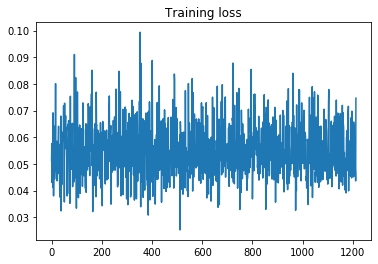

In [4]:
import matplotlib.pyplot as plt
plt.plot(training_loss)
plt.title("Training loss")
# plt.savefig("Training loss.png")
plt.show()
# wykres L za duzy learing rate

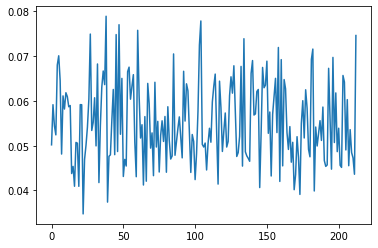

In [5]:
plt.plot(training_loss[1000:])
plt.show()

In [18]:
round(torch.cuda.memory_allocated(0)/1024**3,1)

0.2

In [19]:
round(torch.cuda.memory_cached(0)/1024**3,1)

2.1

ValueError: x and y must have same first dimension, but have shapes (0,) and (1213,)

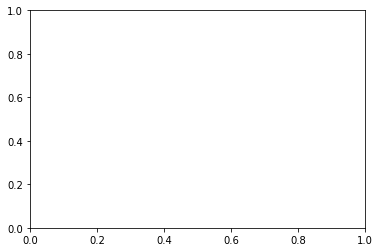

In [6]:
plt.plot(learning_rates,training_loss)
plt.xscale("log")
plt.show()

In [8]:
min(training_loss)

0.014193178154528141

In [9]:
learning_rates[training_loss.index(min(training_loss))]

0.04400001000000003

In [11]:
a = [training_loss[i] - training_loss[i-1] for i in range(1, len(training_loss))]
learning_rates[a.index(max(a))]

0.8130000100000007

In [3]:
import os 
dir_path = os.path.dirname(os.path.realpath("ProjectY.ipynb"))

In [4]:
dir_path

'C:\\PythonScripts'